In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import logging
from IPython.display import Image

In [2]:
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

In [3]:
import importlib
import euler_utils
import plotting_utils
importlib.reload(euler_utils)
importlib.reload(plotting_utils)

/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/lib64/python3.8/site-packages/pyproj/__init__.py:78: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


<module 'plotting_utils' from '/cluster/home/mfrancesc/IVT/eqasim-java/switzerland/WaitTimeValidation/plotting_utils.py'>

In [46]:
last_iter = 200

In [5]:
main_folder = '/cluster/work/ivt_vpl/mfrancesc/SA_scenario/'

In [6]:
data = euler_utils.read_output(main_folder + 'no_rejections_4000_v2', last_iter)
euler_utils.compute_delay_factor_from_estimated(data['drt_trips_stats'])

  0%|          | 0/201 [00:00<?, ?it/s]2023-03-01 09:31:02 INFO     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2023-03-01 09:31:02 INFO     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
100%|██████████| 201/201 [00:00<00:00, 634.89it/s]


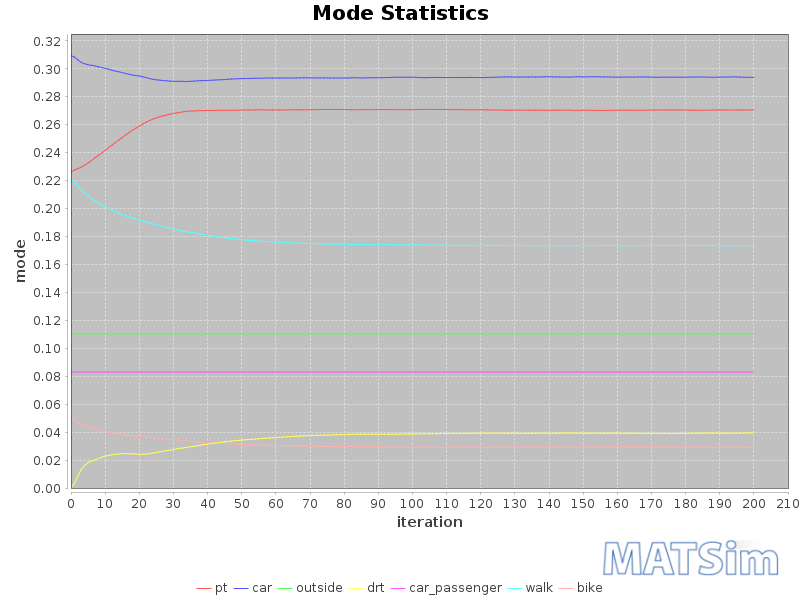

In [7]:
Image(main_folder + 'no_rejections_4000_v2/modestats.png')

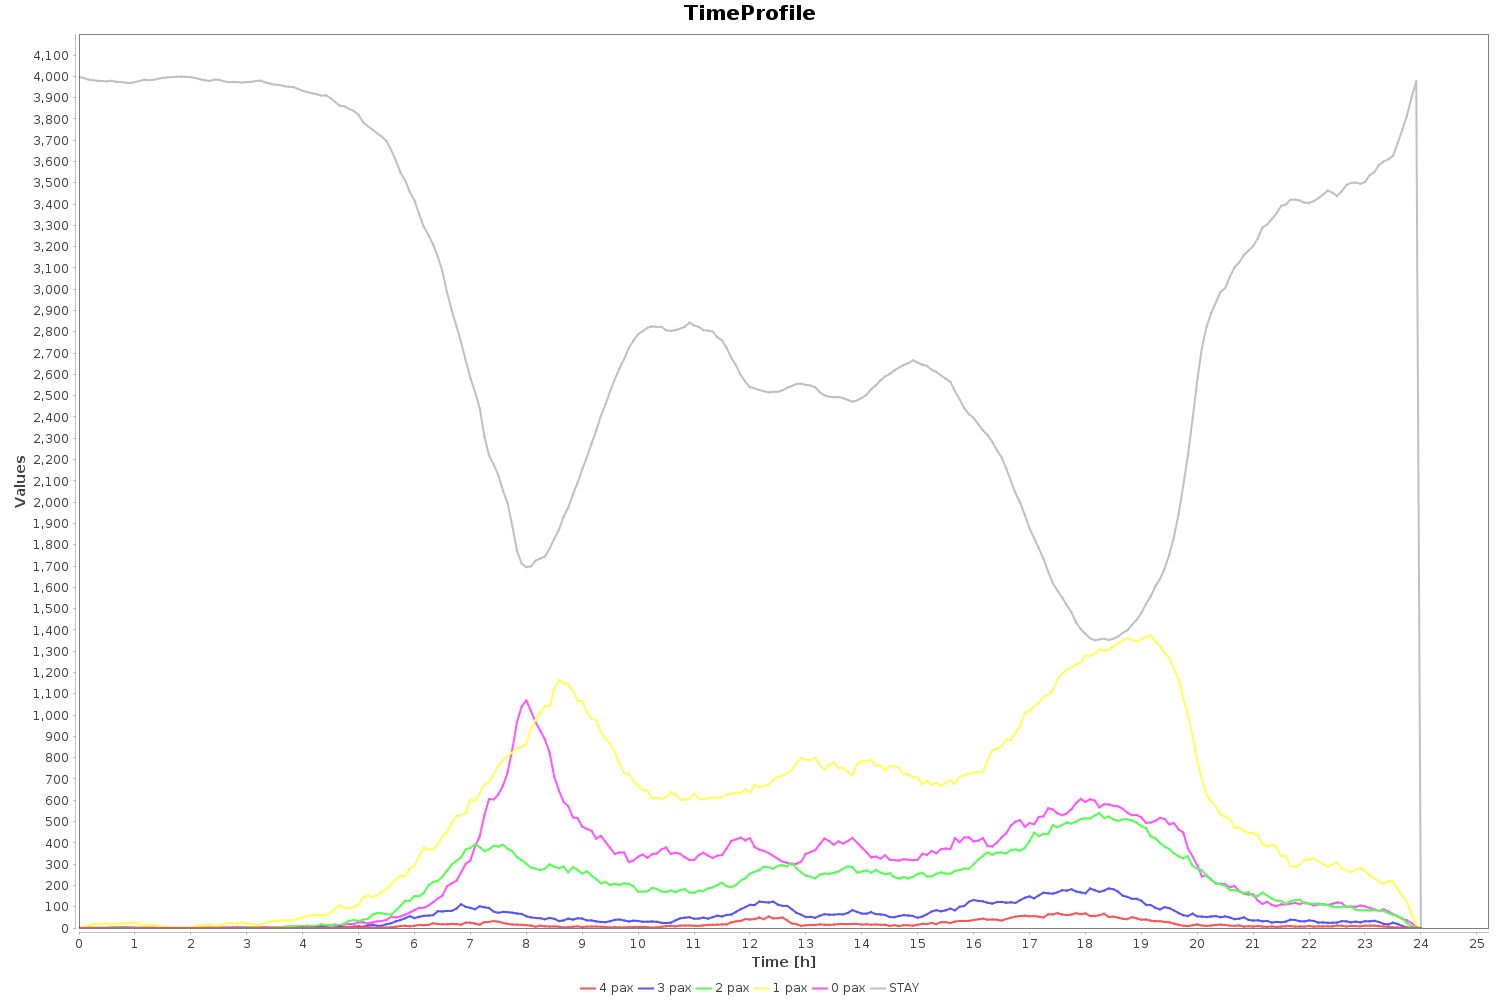

In [8]:
Image(main_folder + 'no_rejections_4000_v2/ITERS/it.200/200.occupancy_time_profiles_Line_drt.png')

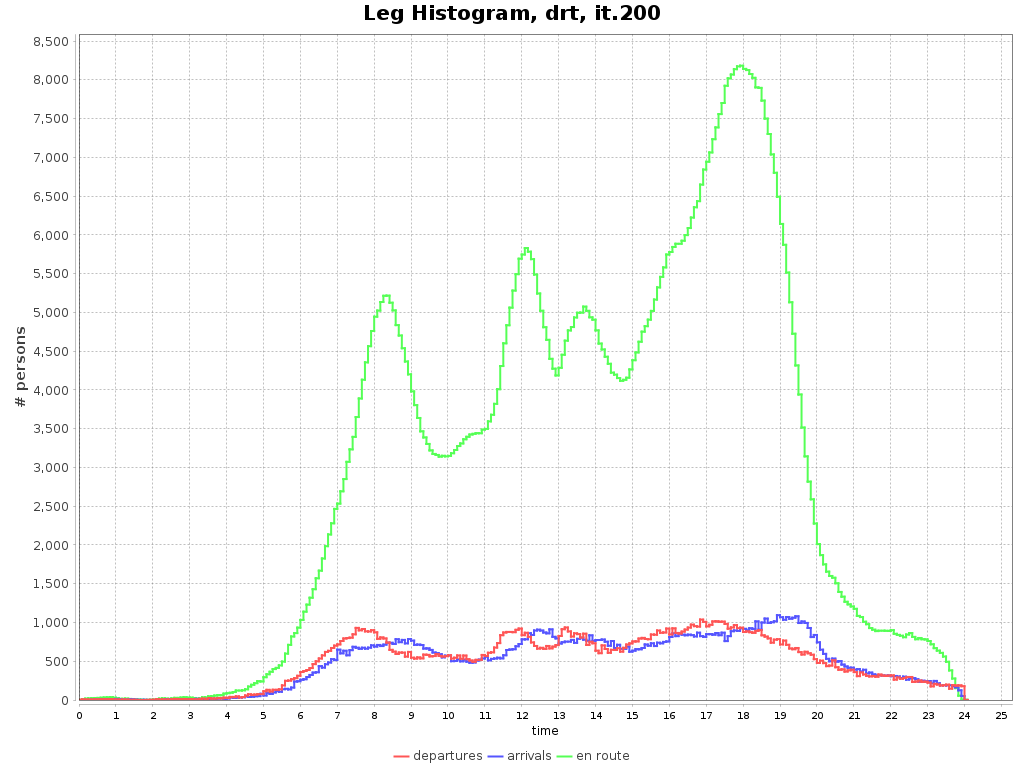

In [11]:
Image(main_folder + 'no_rejections_4000_v2/ITERS/it.200/200.legHistogram_drt.png')

# Euclidean distance distribution

In [56]:
def plot_euclidean_distance_ditribution(it_drt_trips_stats):
    euclidean_distance = np.sqrt((it_drt_trips_stats.startX -it_drt_trips_stats.endX)**2 + (it_drt_trips_stats.startY -it_drt_trips_stats.endY)**2)
    display(euclidean_distance.describe(percentiles=[.25,.50,.75,.90,.95,.99]).to_frame().transpose())
    plt.hist(euclidean_distance / 1000, range=(0,10), density=True)
    plt.xlabel('Euclidean distance (km)')
    plt.ylabel('Number of DRT trips')
    plt.show()

count         mean          std  min         25%          50%  \
0  141318.0  3402.746964  3800.175797  0.0  612.795381  1816.888428   

           75%          90%           95%           99%          max  
0  4951.769013  9322.654702  11607.166513  15877.059663  23442.40389

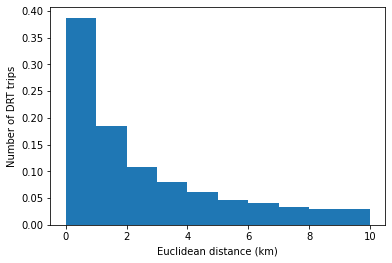

In [57]:
plot_euclidean_distance_ditribution(data['drt_trips_stats'][last_iter])

We see that 75% of the drt trips are of less than 5 km

# Delay factor and wait time

In [51]:
def avg_by_time_bin(drt_trips_stats, column, start_time=6, end_time=24, bin_duration_min=30):
    legs = drt_trips_stats.copy()
    n_bins = (end_time - start_time) * 60 // bin_duration_min
    bins = [start_time*3600 + i*bin_duration_min*60 for i in range(0,n_bins+1)]
    legs['time_bin'] = pd.cut(legs.startTime, bins).map(lambda x: int((x.left + x.right)/2))
    if column == 'compute_total_delay_factor_estimated':
        grouped = legs.groupby(['time_bin'])['totalTravelTime'].sum() / legs.groupby(['time_bin'])['estimatedUnsharedTime'].sum()
    elif column == 'compute_total_delay_factor_router':
        grouped = legs.groupby(['time_bin'])['totalTravelTime'].sum() / legs.groupby(['time_bin'])['routerUnsharedTime'].sum()
    else:
        grouped = legs.groupby(['time_bin'])[column].mean()
    return grouped

In [52]:
def avg_by_euclidean_distance_bin(drt_trips_stats, column, min_distance=0, max_distance=5000, bin_distance_m=200):
    legs = drt_trips_stats.copy()
    n_bins = (max_distance - min_distance) // bin_distance_m
    distance_bins = [i*bin_distance_m for i in range(n_bins + 1)]
    legs['euclidean_distance'] = np.sqrt((legs.startX - legs.endX)**2 + (legs.startY - legs.endY)**2)
    legs['distance_bin'] = pd.cut(legs.euclidean_distance, distance_bins).map(lambda x: int((x.left + x.right)/2))
    if column == 'compute_total_delay_factor_estimated':
        grouped = legs.groupby(['distance_bin'])['totalTravelTime'].sum() / legs.groupby(['distance_bin'])['estimatedUnsharedTime'].sum()
    elif column == 'compute_total_delay_factor_router':
        grouped = legs.groupby(['distance_bin'])['totalTravelTime'].sum() / legs.groupby(['distance_bin'])['routerUnsharedTime'].sum()
    else:
        grouped = legs.groupby(['distance_bin'])[column].mean()
    return grouped

In [53]:
def plot_delay_factor(it_drt_trip_stats, start_time, end_time, bin_duration_min, min_distance, max_distance, bin_distance_m):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    delayFactor_avg = avg_by_time_bin(filtered_without_router_zeros, 'delayFactor', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorEstimatedDRT_avg = avg_by_time_bin(filtered_without_router_zeros, 'delayFactorEstimatedDRT', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorComputedRouter_avg = avg_by_time_bin(filtered_without_router_zeros, 'compute_total_delay_factor_router', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorComputedEstimatedDRT_avg = avg_by_time_bin(filtered_without_router_zeros, 'compute_total_delay_factor_estimated', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    plt.figure(figsize=(15,15))
    
    plt.subplot(2,2,1)
    xticks = [z*3600 for z in range(start_time, end_time+1, 2)]
    xticks_labels = [str(z) + 'h' for z in range(start_time, end_time+1, 2)]
    
    plt.plot(delayFactor_avg.index.values, delayFactor_avg.values, 'ro-', label='Avg of delay factor using router')
    plt.plot(delayFactorEstimatedDRT_avg.index.values, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
    plt.plot(delayFactorComputedRouter_avg.index.values, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
    plt.plot(delayFactorComputedEstimatedDRT_avg.index.values, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
    plt.legend()
    plt.xlim(start_time*3600,end_time*3600)
    plt.xticks(xticks, xticks_labels)
    plt.title('Delay Factor by departure time\n (filtering the trips with 0 predicted time by the router)')
    plt.ylabel('Delay Factor')
    plt.xlabel('Time of the day')

    
    plt.subplot(2,2,3)
    
    delayFactorEstimatedDRT_avg = avg_by_time_bin(it_drt_trip_stats, 'delayFactorEstimatedDRT', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorComputedRouter_avg = avg_by_time_bin(it_drt_trip_stats, 'compute_total_delay_factor_router', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorComputedEstimatedDRT_avg = avg_by_time_bin(it_drt_trip_stats, 'compute_total_delay_factor_estimated', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    plt.plot(delayFactorEstimatedDRT_avg.index.values, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
    plt.plot(delayFactorComputedRouter_avg.index.values, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
    plt.plot(delayFactorComputedEstimatedDRT_avg.index.values, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
    plt.legend()
    plt.xlim(start_time*3600,end_time*3600)
    plt.xticks(xticks, xticks_labels)
    plt.title('Delay Factor by departure time\n (without filtering)')
    plt.ylabel('Delay Factor')
    plt.xlabel('Time of the day')

    
    
    plt.subplot(2,2,2)
    
    delayFactor_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'delayFactor', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorEstimatedDRT_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'delayFactorEstimatedDRT', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorComputedRouter_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'compute_total_delay_factor_router', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorComputedEstimatedDRT_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'compute_total_delay_factor_estimated',min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    plt.plot(np.array(delayFactor_avg.index.values)/1000, delayFactor_avg.values, 'ro-', label='Avg of delay factor using router')
    plt.plot(np.array(delayFactorEstimatedDRT_avg.index.values)/1000, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
    plt.plot(np.array(delayFactorComputedRouter_avg.index.values)/1000, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
    plt.plot(np.array(delayFactorComputedEstimatedDRT_avg.index.values)/1000, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
    plt.legend()
    plt.title('Delay Factor by euclidean distance\n (filtering the trips with 0 predicted time by the router)')
    plt.xlabel('Euclidean distance (km)')
    plt.ylabel('Delay Factor')
    
    plt.subplot(2,2,4)
    
    delayFactor_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'delayFactor', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorEstimatedDRT_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'delayFactorEstimatedDRT', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorComputedRouter_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'compute_total_delay_factor_router', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorComputedEstimatedDRT_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'compute_total_delay_factor_estimated',min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    
    # TODO: Ask if we should plot this one (here we can see that only trips with low distance have 0 prediction)
    plt.plot(np.array(delayFactorEstimatedDRT_avg.index.values)/1000, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
    plt.plot(np.array(delayFactorComputedRouter_avg.index.values)/1000, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
    plt.plot(np.array(delayFactorComputedEstimatedDRT_avg.index.values)/1000, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
    plt.legend()
    plt.title('Delay Factor by euclidean distance\n (without filtering)')
    plt.xlabel('Euclidean distance (km)')
    plt.ylabel('Delay Factor')
    plt.tight_layout()
    plt.show()
    
    

In [54]:
start_time = 6
end_time = 24
bin_duration_min = 15
min_distance = 0
max_distance = 10000
bin_distance_m = 200

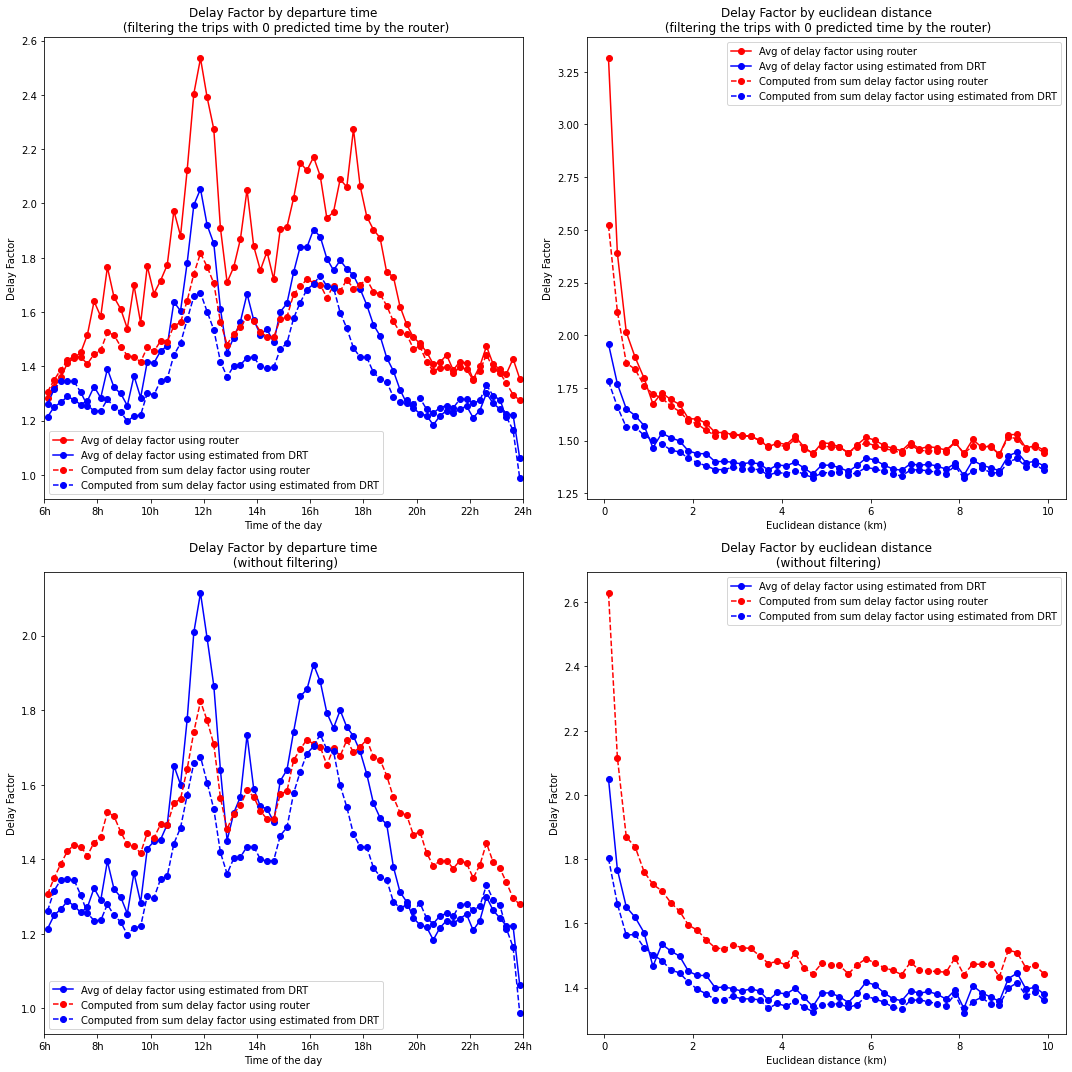

In [18]:
plot_delay_factor(data['drt_trips_stats'][last_iter], start_time, end_time, bin_duration_min,
                 min_distance, max_distance, bin_distance_m)

Here we don't observe the tendency that delay factor increases with euclidean distance

## We redo the top line plots with multiple time and distance bins size

In [27]:
def plot_df_multiple_time_bins(it_drt_trip_stats, start_time, end_time, bin_durations_min):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    n_rows = (len(bin_durations_min) - 1) // 2 + 1
    plt.figure(figsize=(15, n_rows * 7.5))
    
    xticks = [z*3600 for z in range(start_time, end_time+1, 2)]
    xticks_labels = [str(z) + 'h' for z in range(start_time, end_time+1, 2)]
    
    for idx,time_bin in enumerate(bin_durations_min, start=1):
        delayFactor_avg = avg_by_time_bin(filtered_without_router_zeros, 'delayFactor', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=time_bin)
        delayFactorEstimatedDRT_avg = avg_by_time_bin(filtered_without_router_zeros, 'delayFactorEstimatedDRT', start_time=start_time, 
                                         end_time=end_time, bin_duration_min=time_bin)
        delayFactorComputedRouter_avg = avg_by_time_bin(filtered_without_router_zeros, 'compute_total_delay_factor_router', start_time=start_time, 
                                         end_time=end_time, bin_duration_min=time_bin)
        delayFactorComputedEstimatedDRT_avg = avg_by_time_bin(filtered_without_router_zeros, 'compute_total_delay_factor_estimated', start_time=start_time, 
                                         end_time=end_time, bin_duration_min=time_bin)
    
        plt.subplot(n_rows,2,idx)
        plt.plot(delayFactor_avg.index.values, delayFactor_avg.values, 'ro-', label='Avg of delay factor using router')
        plt.plot(delayFactorEstimatedDRT_avg.index.values, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
        plt.plot(delayFactorComputedRouter_avg.index.values, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
        plt.plot(delayFactorComputedEstimatedDRT_avg.index.values, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')

        #plt.plot(delayFactor_avg.index.values, delayFactor_avg.values, 'o-', label=str(time_bin) + 'min')
        plt.legend()
        plt.xlim(start_time*3600,end_time*3600)
        plt.xticks(xticks, xticks_labels)
        plt.title('Delay Factor by departure time\n (filtering the trips with 0 predicted time by the router)\nTime bin = ' + str(time_bin) + ' min')
        plt.ylabel('Delay Factor')
        plt.xlabel('Time of the day')
    
    plt.tight_layout()
    plt.show()
        
    

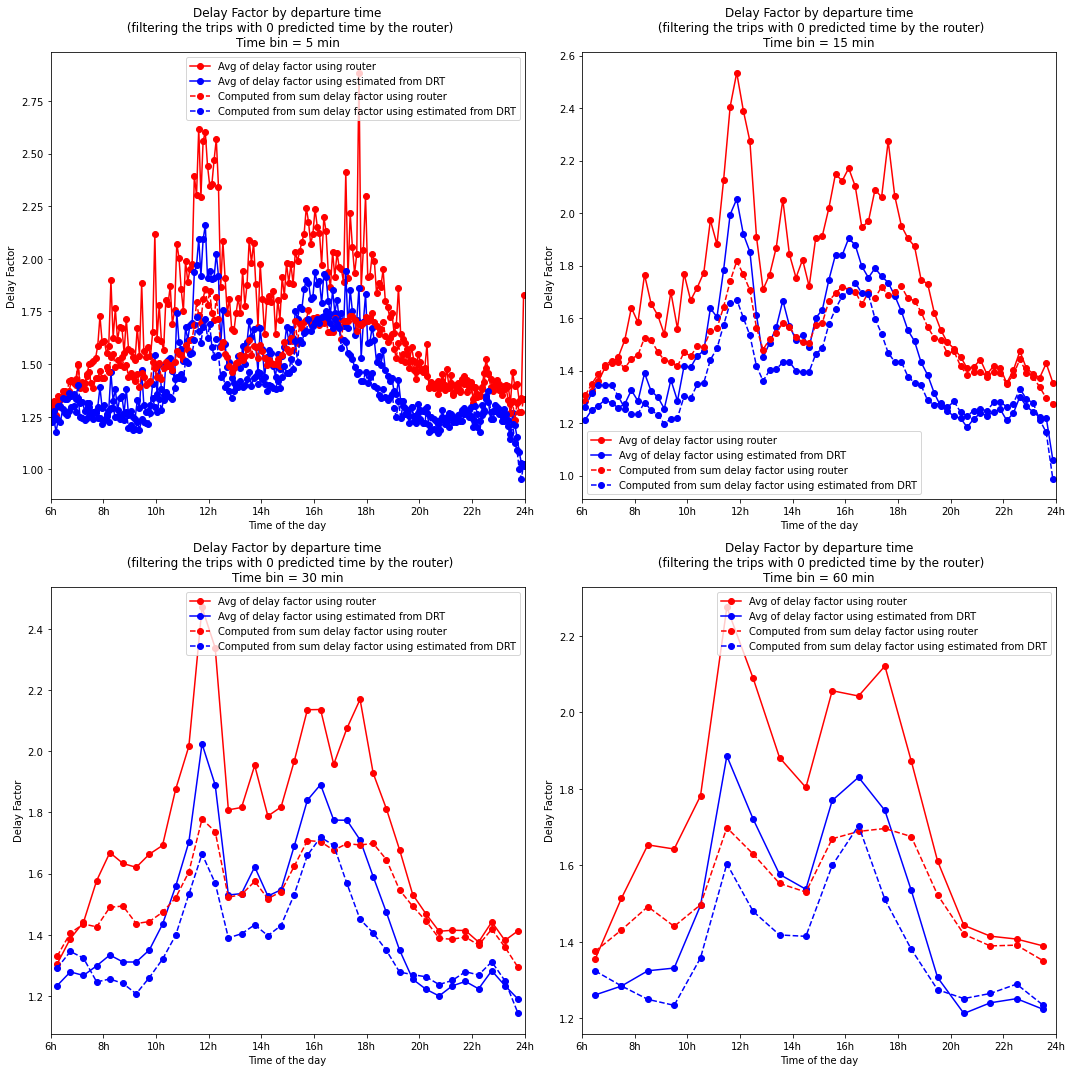

In [28]:
plot_df_multiple_time_bins(data['drt_trips_stats'][last_iter], start_time, end_time, [5,15,30,60])

In [29]:
def plot_df_multiple_distance_bins(it_drt_trip_stats,  min_distance, max_distance, bin_distances_m):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    n_rows = (len(bin_distances_m) - 1) // 2 + 1
    plt.figure(figsize=(15, n_rows * 7.5))
    
    for idx,distance_bin in enumerate(bin_distances_m, start=1):
        delayFactor_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'delayFactor', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=distance_bin)
        delayFactorEstimatedDRT_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'delayFactorEstimatedDRT', min_distance=min_distance, 
                                         max_distance=max_distance, bin_distance_m=distance_bin)
        delayFactorComputedRouter_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'compute_total_delay_factor_router', min_distance=min_distance, 
                                         max_distance=max_distance, bin_distance_m=distance_bin)
        delayFactorComputedEstimatedDRT_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'compute_total_delay_factor_estimated',min_distance=min_distance, 
                                         max_distance=max_distance, bin_distance_m=distance_bin)
        plt.subplot(n_rows,2,idx)
        
        plt.plot(np.array(delayFactor_avg.index.values)/1000, delayFactor_avg.values, 'ro-', label='Avg of delay factor using router')
        plt.plot(np.array(delayFactorEstimatedDRT_avg.index.values)/1000, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
        plt.plot(np.array(delayFactorComputedRouter_avg.index.values)/1000, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
        plt.plot(np.array(delayFactorComputedEstimatedDRT_avg.index.values)/1000, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
        plt.legend()
        plt.title('Delay Factor by euclidean distance\n (filtering the trips with 0 predicted time by the router)\nDistance bin = ' + str(distance_bin) + 'm')
        plt.xlabel('Euclidean distance (km)')
        plt.ylabel('Delay Factor')
    
    plt.tight_layout()
    plt.show()

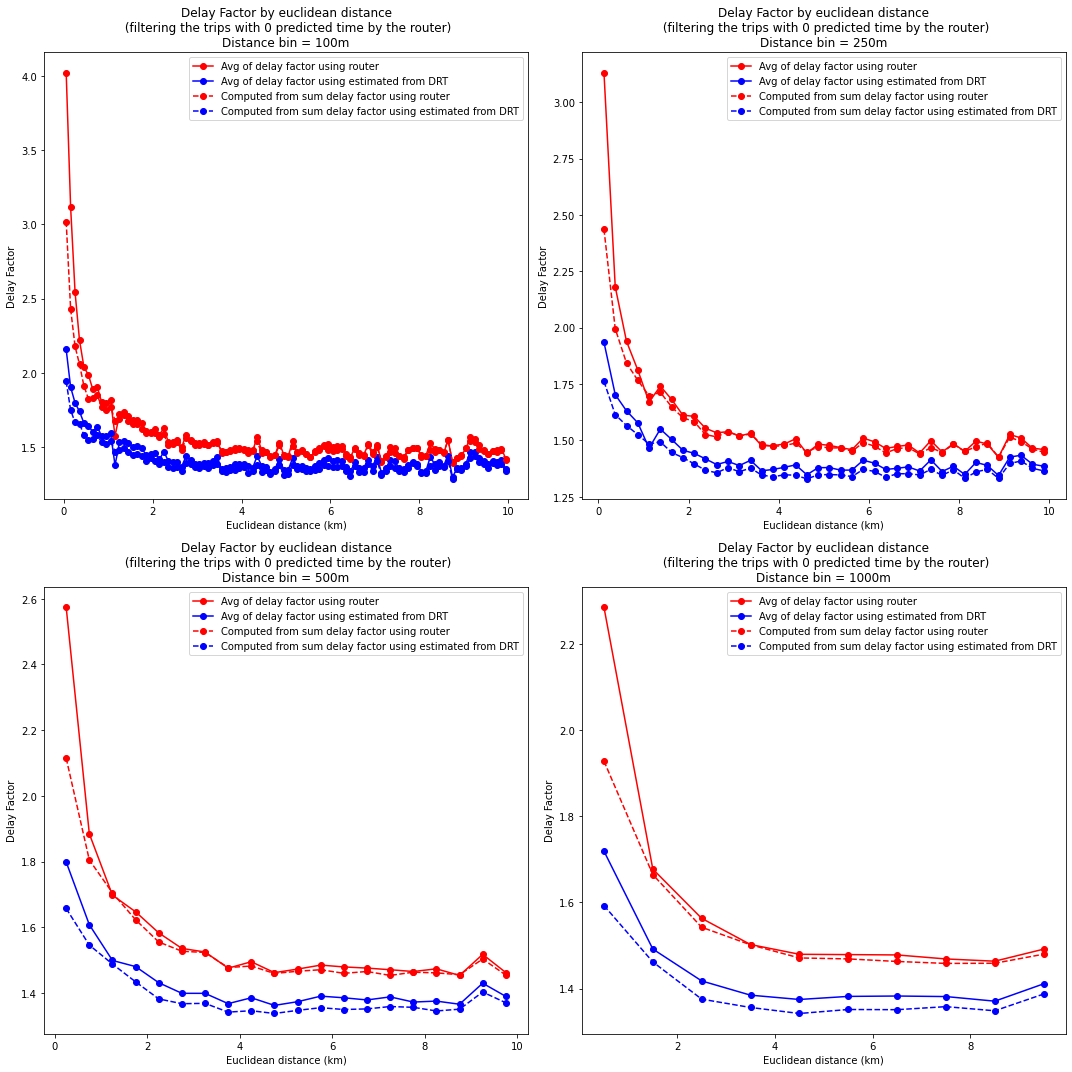

In [30]:
plot_df_multiple_distance_bins(data['drt_trips_stats'][last_iter], min_distance, max_distance, [100,250,500,1000])

The estimated travel time by the DRT is usually closer to the travel time -> DF for the estimated from DRT is smaller

In [47]:
def plot_waiting_time(it_drt_trip_stats, start_time, end_time, bin_duration_min, min_distance, max_distance, bin_distance_m):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    
    waitTime_avg = avg_by_time_bin(filtered_without_router_zeros, 'waitTime', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    
    plt.figure(figsize=(15,15))
    
    plt.subplot(2,2,1)
    xticks = [z*3600 for z in range(start_time, end_time+1, 2)]
    xticks_labels = [str(z) + 'h' for z in range(start_time, end_time+1, 2)]
    
    plt.plot(waitTime_avg.index.values, waitTime_avg.values/60, 'o-', label='Avg of wait time')
    plt.xlim(start_time*3600,end_time*3600)
    plt.xticks(xticks, xticks_labels)
    plt.title('Wait time by departure time\n (filtering the trips with 0 predicted time by the router)')
    plt.ylabel('Wait time (min)')
    plt.xlabel('Time of the day')
    
    plt.subplot(2,2,3)
    waitTime_avg = avg_by_time_bin(it_drt_trip_stats, 'waitTime', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    plt.plot(waitTime_avg.index.values, waitTime_avg.values/60, 'o-', label='Avg of wait time')
    plt.xlim(start_time*3600,end_time*3600)
    plt.xticks(xticks, xticks_labels)
    plt.title('Wait time by departure time\n (without filtering)')
    plt.ylabel('Wait time (min)')
    plt.xlabel('Euclidean distance (km)')
    
    plt.subplot(2,2,2)
    waitTime_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'waitTime', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    plt.plot(np.array(waitTime_avg.index.values) / 1000, waitTime_avg.values/60, 'o-', label='Avg of wait time')
    plt.title('Wait time by euclidean distance\n (filtering the trips with 0 predicted time by the router)')
    plt.xlabel('Euclidean distance (km)')
    plt.subplot(2,2,4)
    waitTime_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'waitTime', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    plt.plot(np.array(waitTime_avg.index.values) / 1000, waitTime_avg.values/60, 'o-', label='Avg of wait time')
    plt.title('Wait time by euclidean distance\n (without filtering)')
    plt.ylabel('Wait time (min)')
    plt.xlabel('Euclidean distance (km)')
    
    
    plt.show()
    

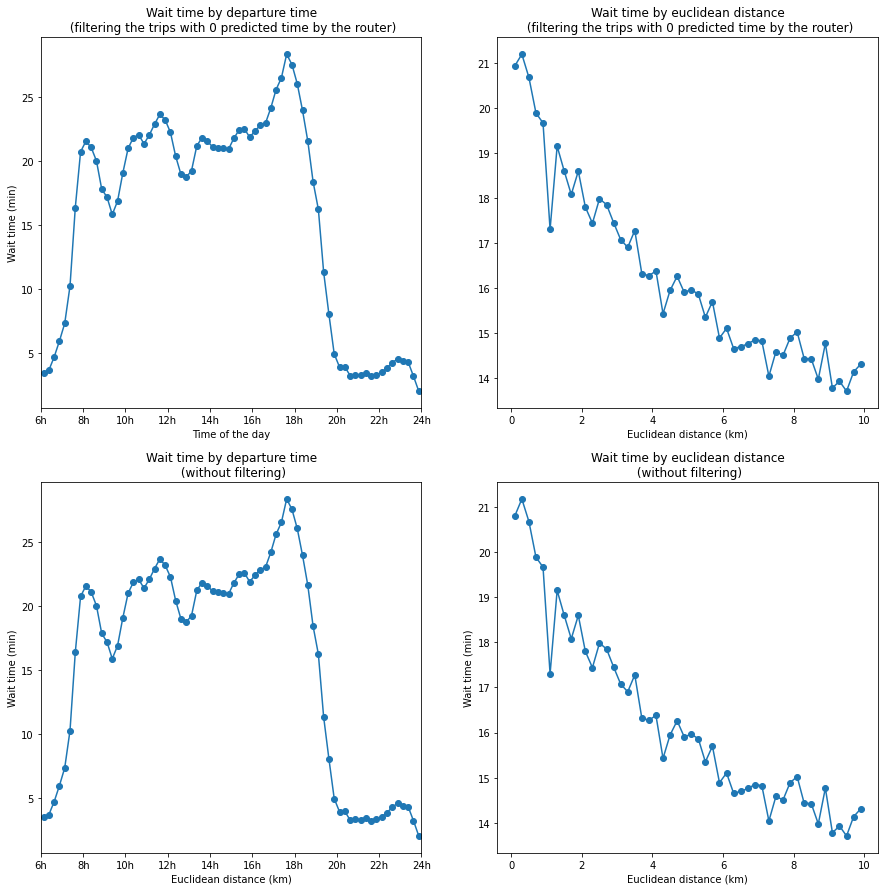

In [41]:
plot_waiting_time(data['drt_trips_stats'][last_iter], start_time, end_time, bin_duration_min,
                 min_distance, max_distance, bin_distance_m)

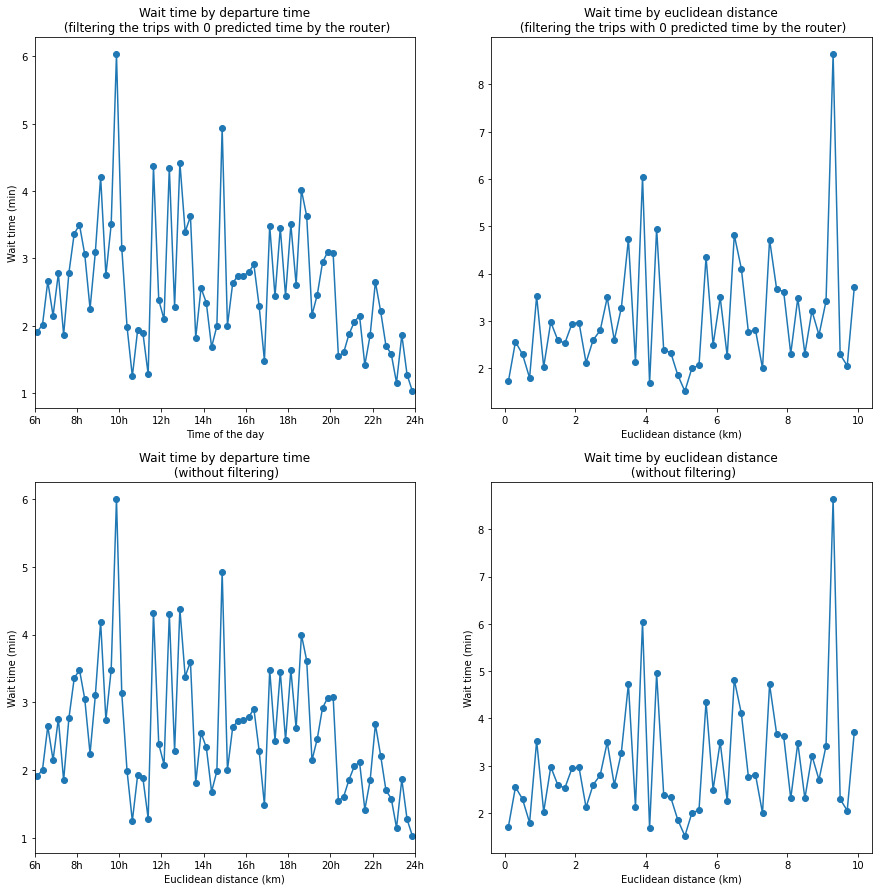

In [55]:
plot_waiting_time(data['drt_trips_stats'][1], start_time, end_time, bin_duration_min,
                 min_distance, max_distance, bin_distance_m)

## We redo the top line plots with different time and distance bins

In [35]:
def plot_waiting_time_multiple_time_bins(it_drt_trip_stats, start_time, end_time, bin_durations_min):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    n_rows = (len(bin_durations_min) - 1) // 2 + 1
    plt.figure(figsize=(15, n_rows * 7.5))
    
    xticks = [z*3600 for z in range(start_time, end_time+1, 2)]
    xticks_labels = [str(z) + 'h' for z in range(start_time, end_time+1, 2)]
    
    for idx,time_bin in enumerate(bin_durations_min, start=1):
        waitTime_avg = avg_by_time_bin(filtered_without_router_zeros, 'waitTime', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=time_bin)
        
        plt.subplot(n_rows,2,idx)
        plt.plot(waitTime_avg.index.values, waitTime_avg.values/60, 'o-', label='Avg of wait time')        
        plt.xlim(start_time*3600,end_time*3600)
        plt.xticks(xticks, xticks_labels)
        plt.title('Wait time by departure time\n (filtering the trips with 0 predicted time by the router)\nTime bin = ' + str(time_bin) + ' min')
        plt.ylabel('Wait time (min)')
        plt.xlabel('Time of the day')
    
    plt.tight_layout()
    plt.show()
        
    

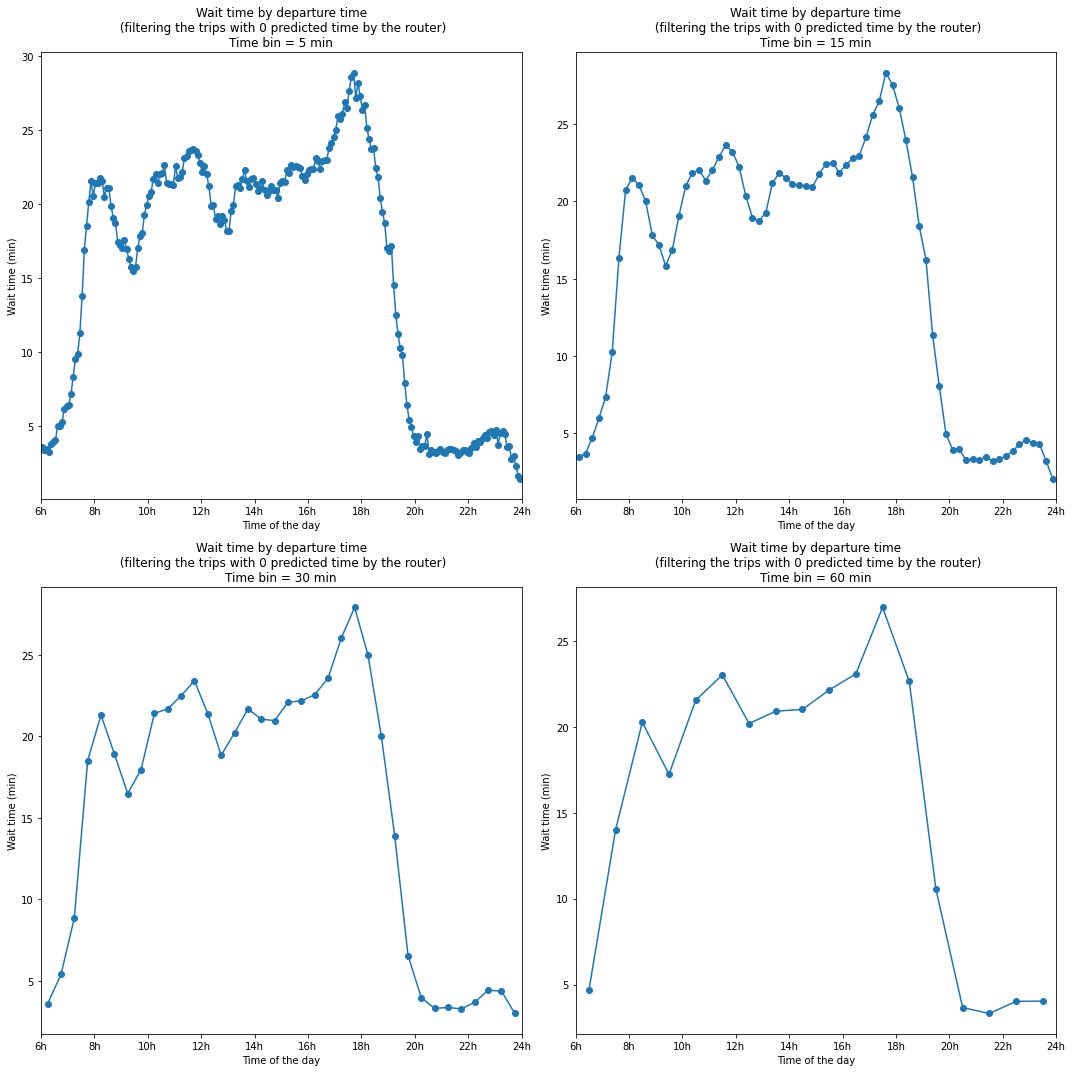

In [37]:
plot_waiting_time_multiple_time_bins(data['drt_trips_stats'][last_iter], start_time, end_time, [5,15,30,60])

In [42]:
def plot_waiting_time_multiple_distance_bins(it_drt_trip_stats,  min_distance, max_distance, bin_distances_m):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    n_rows = (len(bin_distances_m) - 1) // 2 + 1
    plt.figure(figsize=(15, n_rows * 7.5))
    
    for idx,distance_bin in enumerate(bin_distances_m, start=1):
        plt.subplot(n_rows,2,idx)
        waitTime_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'waitTime', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=distance_bin)
        plt.plot(np.array(waitTime_avg.index.values) / 1000, waitTime_avg.values/60, 'o-', label='Avg of wait time')
        plt.title('Wait time by euclidean distance\n (filtering the trips with 0 predicted time by the router)\nDistance bin = ' + str(distance_bin) + 'm')
        plt.xlabel('Euclidean distance (km)')
    
    plt.tight_layout()
    plt.show()

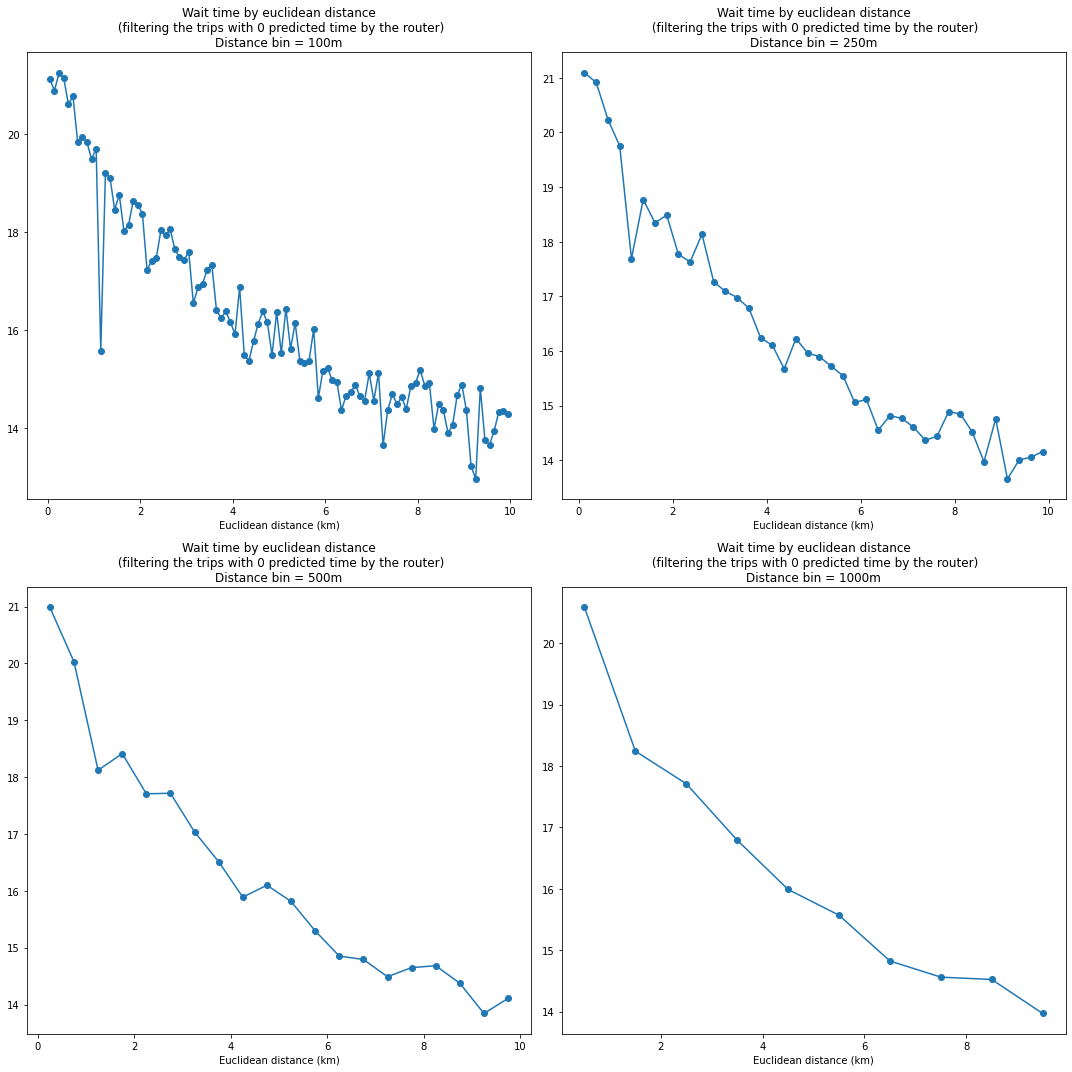

In [43]:
plot_waiting_time_multiple_distance_bins(data['drt_trips_stats'][last_iter], min_distance, max_distance, [100,250,500,1000])

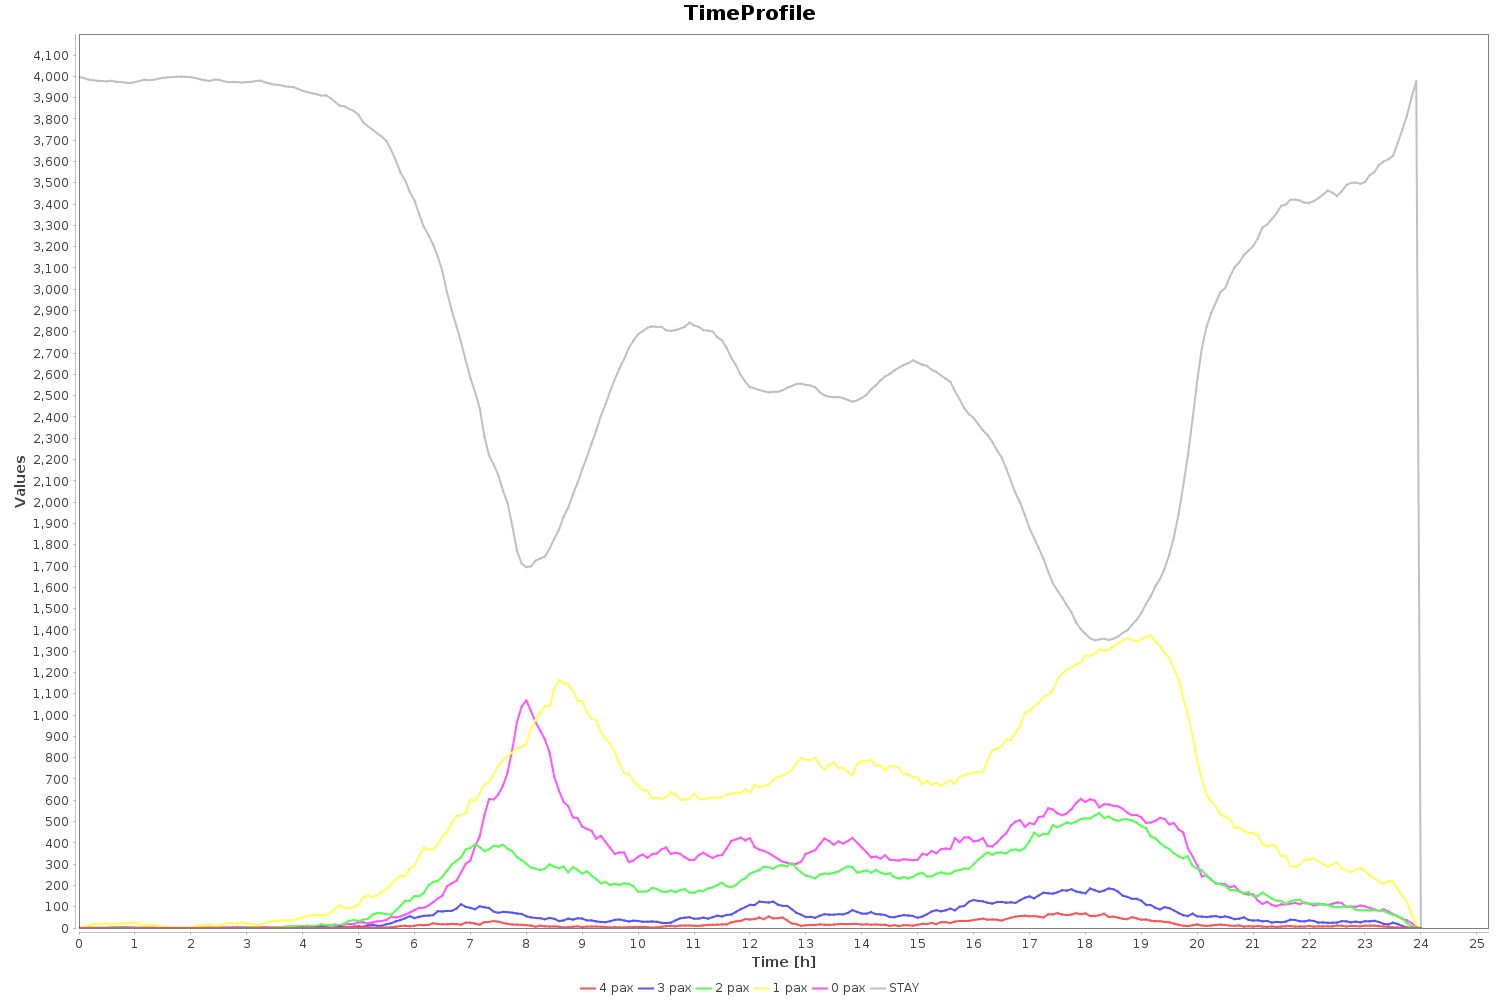

In [12]:
Image(main_folder + 'no_rejections_4000_v2/ITERS/it.200/200.occupancy_time_profiles_Line_drt.png')

In [14]:
import geopandas

/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/lib64/python3.8/site-packages/pyproj/__init__.py:78: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))
/cluster/home/mfrancesc/.local/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-14-fc7d1d298f0c>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, Geo

In [15]:
trip_stats = data['drt_trips_stats'][last_iter].copy(deep=True)
gdf = geopandas.GeoDataFrame(
    trip_stats, geometry=geopandas.points_from_xy(trip_stats.startX, trip_stats.startY))

In [16]:
gdf.crs = 'EPSG:2056'

<AxesSubplot:>

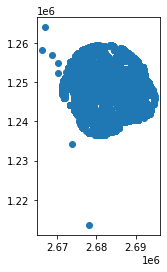

In [18]:
gdf.plot()

In [19]:
main_folder

'/cluster/work/ivt_vpl/mfrancesc/SA_scenario/'

In [22]:
df = pd.read_csv(main_folder+'no_rejections_4000_v2/ITERS/it.200/200.drt_idleVehiclesPerZoneXY.csv', sep=';')

In [27]:
idle_veh = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.X, df.Y))

In [28]:
idle_veh

zone          X          Y  time  idleDRTVehicles  \
0      46600  2631750.0  1238250.0   0.0                0   
1      46601  2631750.0  1238750.0   0.0                0   
2      60904  2655250.0  1222750.0   0.0                0   
3      46604  2631750.0  1240250.0   0.0                0   
4      54232  2644250.0  1241750.0   0.0                0   
...      ...        ...        ...   ...              ...   
51272  27312  2600250.0  1201750.0   0.0                0   
51273  84776  2694250.0  1263750.0   0.0                0   
51274  30958  2606250.0  1194750.0   0.0                0   
51275  84773  2694250.0  1262250.0   0.0                0   
51276  84772  2694250.0  1261750.0   0.0                0   

                              geometry  
0      POINT (2631750.000 1238250.000)  
1      POINT (2631750.000 1238750.000)  
2      POINT (2655250.000 1222750.000)  
3      POINT (2631750.000 1240250.000)  
4      POINT (2644250.000 1241750.000)  
...                                ...  
51272  POINT (2600250.000 1201750.000)  
51273  POINT (2694250.000 1263750.000)  
51274  POINT (2606250.000 1194750.000)  
51275  POINT (2694250.000 1262250.000)  
51276  POINT (2694250.000 1261750.000)  

[51277 rows x 6 columns]

In [41]:
idle_veh[idle_veh.idleDRTVehicles != 0]

zone          X          Y     time  idleDRTVehicles  \
18     76491  2680750.0  1238750.0  71275.0                1   
25     76498  2680750.0  1242250.0      0.0                1   
26     76498  2680750.0  1242250.0      0.0                2   
27     76498  2680750.0  1242250.0      0.0                3   
28     76498  2680750.0  1242250.0      0.0                4   
...      ...        ...        ...      ...              ...   
51209  84734  2694250.0  1242750.0  27143.0                1   
51211  84734  2694250.0  1242750.0  33571.0                1   
51213  84734  2694250.0  1242750.0  34048.0                1   
51214  84734  2694250.0  1242750.0  34054.0                2   
51215  84734  2694250.0  1242750.0  34069.0                1   

                              geometry  
18     POINT (2680750.000 1238750.000)  
25     POINT (2680750.000 1242250.000)  
26     POINT (2680750.000 1242250.000)  
27     POINT (2680750.000 1242250.000)  
28     POINT (2680750.000 1242250.000)  
...                                ...  
51209  POINT (2694250.000 1242750.000)  
51211  POINT (2694250.000 1242750.000)  
51213  POINT (2694250.000 1242750.000)  
51214  POINT (2694250.000 1242750.000)  
51215  POINT (2694250.000 1242750.000)  

[43058 rows x 6 columns]

In [40]:
idle_veh[idle_veh.idleDRTVehicles != 0].time.value_counts()

0.0        4000
86400.0    3464
24086.0       8
65316.0       7
73596.0       7
           ... 
51915.0       1
31394.0       1
19909.0       1
83145.0       1
69643.0       1
Name: time, Length: 25954, dtype: int64

In [34]:
idle_veh.crs = 'EPSG:2056'

In [37]:
idle_veh[idle_veh.idleDRTVehicles > 1000].explore(column='idleDRTVehicles',legend=True)


<AxesSubplot:>

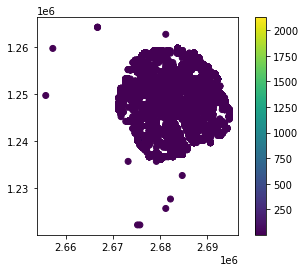

In [32]:
idle_veh[idle_veh.idleDRTVehicles != 0].plot(column='idleDRTVehicles',legend=True)


In [64]:
vehicles = pd.read_csv(main_folder + 'no_rejections_4000_v2/ITERS/it.200/200.vehicleDistanceStats_drt.csv', sep=';')

In [65]:
vehicles.head()

vehicleId  drivenDistance_m  occupiedDistance_m  emptyDistance_m  \
0   drt1471         337252.38           260127.58         77124.79   
1   drt1470         430997.53           336100.95         94896.58   
2   drt1473         389921.82           283025.00        106896.82   
3   drt1472         333053.26           275199.09         57854.17   
4   drt1475         531698.57           406732.19        124966.39   

   passengerDistanceTraveled_pm  
0                     375600.73  
1                     491586.76  
2                     396313.17  
3                     442022.51  
4                     599829.18

In [66]:
vehicles.passengerDistanceTraveled_pm.sum()/ vehicles.occupiedDistance_m.sum()

1.4348374397886512

In [69]:
data['drt_trips_stats'][last_iter].delayFactor.describe()

count    141318.000000
mean          1.812576
std           3.620127
min           0.166125
25%           1.078405
50%           1.216980
75%           1.625403
max         803.200000
Name: delayFactor, dtype: float64

In [71]:
(data['drt_trips_stats'][last_iter].waitTime / 60).describe()

count    141318.000000
mean         17.831351
std          12.619777
min           0.016667
25%           6.250000
50%          17.850000
75%          26.733333
max         179.466667
Name: waitTime, dtype: float64

# Difference between router and estimated

In [44]:
def plot_difference_estimated_router(it_drt_trip_stats):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    abs_difference = np.abs(filtered_without_router_zeros['estimatedUnsharedTime'] - filtered_without_router_zeros['routerUnsharedTime'])
    abs_difference_min = abs_difference / 60 #absolute difference in minutes
    rel_difference = abs_difference / filtered_without_router_zeros['estimatedUnsharedTime']
    print('Description of abs difference in minutes')
    display(abs_difference_min.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99,0.999]).to_frame().transpose())
    print('Description of relative difference')
    display(rel_difference.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99,0.999]).to_frame().transpose())
    plt.figure(figsize=(15,20))
    plt.subplot(2,2,1)
    plt.hist(abs_difference_min, bins=100, range=(0,15), density=True)
    plt.title('Absolute difference')
    plt.xlabel('difference (min)')
    plt.subplot(2,2,2)
    plt.hist(rel_difference, bins=100, range=(0,1), density=True)
    plt.title('Relative difference')
    plt.subplot(2,2,3)
    plt.boxplot(abs_difference_min, positions=[1])
    plt.ylim(-1,15)
    ax2 = plt.gca().twinx()
    ax2.boxplot(abs_difference_min, positions=[2])
    plt.xticks([1,2],['Zoomed','Non zoomed'])
    plt.subplot(2,2,4)
    plt.boxplot(rel_difference, positions=[1])
    plt.ylim(-0.1,1)
    ax2 = plt.gca().twinx()
    ax2.boxplot(rel_difference, positions=[2])
    plt.xticks([1,2],['Zoomed','Non zoomed'])
    plt.tight_layout()
    plt.show()

In [45]:
data['drt_trips_stats'][last_iter].iloc[np.abs(data['drt_trips_stats'][last_iter]['estimatedUnsharedTime'] - data['drt_trips_stats'][last_iter]['routerUnsharedTime']).argmax()]

personId                   2.017400e+14
startTime                  2.507500e+04
totalTravelTime            6.544000e+03
routerUnsharedTime         1.579781e+03
estimatedUnsharedTime      4.634788e+03
delayFactor                4.142346e+00
waitTime                   1.027000e+03
startX                     2.683944e+06
startY                     1.253047e+06
endX                       2.693942e+06
endY                       1.242801e+06
delayFactorEstimatedDRT    1.411931e+00
Name: 137849, dtype: float64

Description of abs difference in minutes


count      mean       std       min       25%       50%       75%  \
0  140362.0  1.021006  2.089001  0.000036  0.235152  0.405098  0.826576   

        90%       95%        99%      99.9%        max  
0  2.115878  4.107867  11.676829  20.840008  50.916788

Description of relative difference


count      mean     std       min      25%      50%       75%       90%  \
0  140362.0  0.133678  0.1441  0.000004  0.04155  0.08948  0.174375  0.306559   

      95%       99%     99.9%        max  
0  0.4109  0.643135  0.923077  14.957049

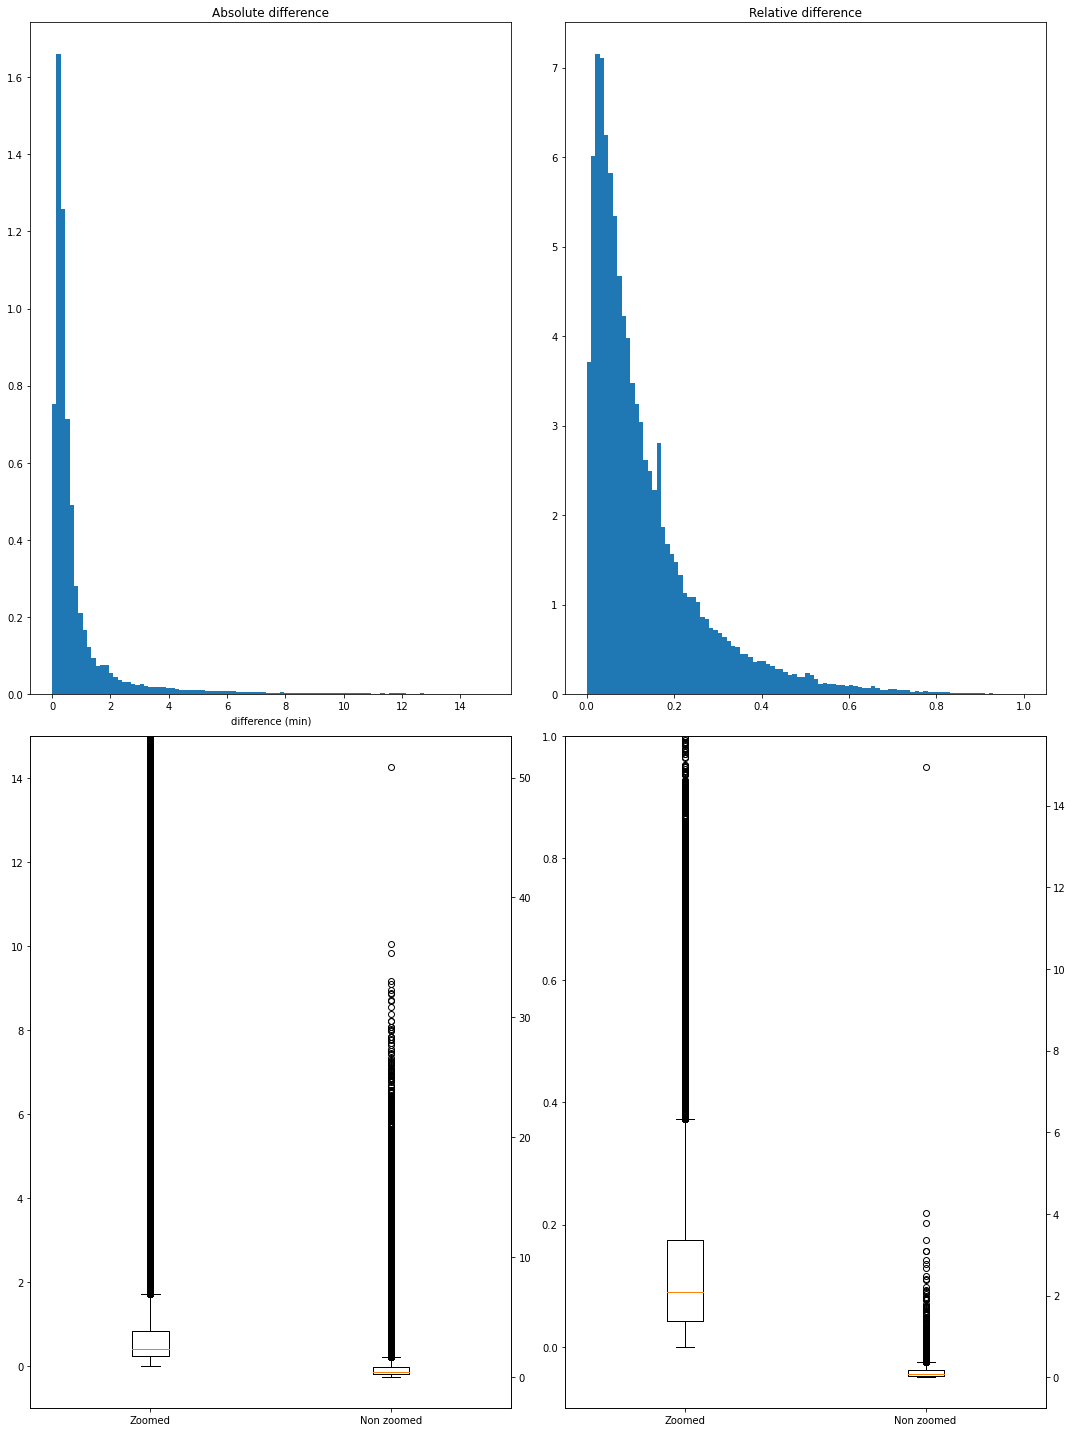

In [46]:
plot_difference_estimated_router(data['drt_trips_stats'][last_iter])

In [47]:
def show_top_differences(it_drt_trip_stats, n=20):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0].copy(deep=True)
    filtered_without_router_zeros['abs_difference'] = np.abs(filtered_without_router_zeros['estimatedUnsharedTime'] - filtered_without_router_zeros['routerUnsharedTime'])
    filtered_without_router_zeros['abs_difference_min'] = filtered_without_router_zeros['abs_difference'] / 60 #absolute difference in minutes
    filtered_without_router_zeros['rel_difference'] = filtered_without_router_zeros['abs_difference'] / filtered_without_router_zeros['estimatedUnsharedTime']
    
    cols = ['startTime', 'totalTravelTime', 'routerUnsharedTime', 'estimatedUnsharedTime', 'delayFactor', 'delayFactorEstimatedDRT', 'abs_difference', 'abs_difference_min', 'rel_difference']

    top_abs_diff = filtered_without_router_zeros['abs_difference'].sort_values(ascending=False)[0:n].index.values
    top_rel_diff = filtered_without_router_zeros['rel_difference'].sort_values(ascending=False)[0:n].index.values
    display(filtered_without_router_zeros.loc[top_abs_diff][cols])
    display(filtered_without_router_zeros.loc[top_rel_diff][cols])
#no_rej_4000['drt_trips_stats'][100].iloc[np.abs(no_rej_4000['drt_trips_stats'][100]['estimatedUnsharedTime'] - no_rej_4000['drt_trips_stats'][100]['routerUnsharedTime']).argmax()]

In [48]:
show_top_differences(data['drt_trips_stats'][last_iter])

startTime  totalTravelTime  routerUnsharedTime  estimatedUnsharedTime  \
137849    25075.0           6544.0            1579.781            4634.788264   
124186    76312.0           3170.0            1377.438            3545.217119   
31939     78058.0           3645.0            1217.932            3340.961598   
11111     75363.0           2459.0            1363.085            3345.617798   
40561     71139.0           1127.0             590.252            2558.695816   
68789     68213.0           3797.0            1359.403            3294.162042   
104214    71205.0           2114.0             486.641            2408.188393   
127962    76970.0           1347.0             565.271            2483.370507   
69633     80856.0           2280.0            1455.978            3345.400165   
128009    82734.0           1749.0            1489.277            3372.356467   
8021      64816.0            663.0             335.966            2188.165926   
64350     74248.0           1189.0             730.448            2548.560608   
71115     81005.0           1531.0             748.710            2533.195977   
4599      66986.0           5052.0            1462.787            3243.522192   
68620     75436.0            477.0             452.927            2203.691979   
71738     75508.0            807.0             747.335            2497.422470   
7085      83056.0           1940.0            1158.573            2901.268170   
83689     65333.0           3404.0            1796.362            3533.907539   
49111     69627.0           3815.0            1269.158            3001.138992   
118781    74151.0           3005.0            1563.466            3267.508774   

        delayFactor  delayFactorEstimatedDRT  abs_difference  \
137849     4.142346                 1.411931     3055.007264   
124186     2.301374                 0.894162     2167.779119   
31939      2.992778                 1.091003     2123.029598   
11111      1.803996                 0.734991     1982.532798   
40561      1.909354                 0.440459     1968.443816   
68789      2.793138                 1.152645     1934.759042   
104214     4.344065                 0.877838     1921.547393   
127962     2.382928                 0.542408     1918.099507   
69633      1.565958                 0.681533     1889.422165   
128009     1.174395                 0.518628     1883.079467   
8021       1.973414                 0.302993     1852.199926   
64350      1.627768                 0.466538     1818.112608   
71115      2.044850                 0.604375     1784.485977   
4599       3.453681                 1.557566     1780.735192   
68620      1.053150                 0.216455     1750.764979   
71738      1.079837                 0.323133     1750.087470   
7085       1.674474                 0.668673     1742.695170   
83689      1.894941                 0.963240     1737.545539   
49111      3.005930                 1.271184     1731.980992   
118781     1.922012                 0.919661     1704.042774   

        abs_difference_min  rel_difference  
137849           50.916788        0.659147  
124186           36.129652        0.611466  
31939            35.383827        0.635455  
11111            33.042213        0.592576  
40561            32.807397        0.769315  
68789            32.245984        0.587330  
104214           32.025790        0.797922  
127962           31.968325        0.772378  
69633            31.490369        0.564782  
128009           31.384658        0.558387  
8021             30.869999        0.846462  
64350            30.301877        0.713388  
71115            29.741433        0.704441  
4599             29.678920        0.549013  
68620            29.179416        0.794469  
71738            29.168125        0.700757  
7085             29.044920        0.600667  
83689            28.959092        0.491678  
49111            28.866350        0.577108  
118781           28.400713        0.521511

startTime  totalTravelTime  routerUnsharedTime  estimatedUnsharedTime  \
52582     64405.0           1330.0             978.023              61.290968   
85224     60074.0            671.0             581.786             115.883198   
110899    61996.0            351.0             241.927              50.612749   
117907    59321.0            508.0             410.630              93.951485   
43801     70553.0             96.0             117.624              28.665386   
25656     65251.0           1419.0            1292.111             315.224874   
115367    63133.0           1700.0             858.937             222.506283   
74305     60818.0           1108.0            1096.119             290.729705   
32666     42046.0            542.0             519.837             141.344735   
103296    62513.0           1747.0             993.342             285.103185   
92642     58743.0            827.0             738.201             215.984375   
124198    61388.0            795.0             681.424             201.204122   
16670     61740.0           1351.0            1237.174             385.982642   
99021     63267.0           1306.0            1117.243             357.176987   
119108    69230.0           2153.0             932.874             299.386200   
86028     60112.0            535.0             340.854             110.813504   
114573    63391.0           2932.0            1344.575             441.767286   
39371     61073.0           1200.0             883.605             296.872283   
10910     61320.0            837.0             778.830             264.176707   
101070    35881.0            820.0             793.204             270.341872   

        delayFactor  delayFactorEstimatedDRT  abs_difference  \
52582      1.359886                21.699772      916.732032   
85224      1.153345                 5.790313      465.902802   
110899     1.450851                 6.935012      191.314251   
117907     1.237123                 5.407046      316.678515   
43801      0.816160                 3.348987       88.958614   
25656      1.098203                 4.501548      976.886126   
115367     1.979191                 7.640234      636.430717   
74305      1.010839                 3.811100      805.389295   
32666      1.042635                 3.834596      378.492265   
103296     1.758709                 6.127606      708.238815   
92642      1.120291                 3.828981      522.216625   
124198     1.166674                 3.951211      480.219878   
16670      1.092005                 3.500157      851.191358   
99021      1.168949                 3.656451      760.066013   
119108     2.307922                 7.191380      633.487800   
86028      1.569587                 4.827931      230.040496   
114573     2.180615                 6.636979      902.807714   
39371      1.358073                 4.042142      586.732717   
10910      1.074689                 3.168334      514.653293   
101070     1.033782                 3.033196      522.862128   

        abs_difference_min  rel_difference  
52582            15.278867       14.957049  
85224             7.765047        4.020452  
110899            3.188571        3.779962  
117907            5.277975        3.370660  
43801             1.482644        3.103346  
25656            16.281435        3.099013  
115367           10.607179        2.860282  
74305            13.423155        2.770234  
32666             6.308204        2.677795  
103296           11.803980        2.484149  
92642             8.703610        2.417844  
124198            8.003665        2.386730  
16670            14.186523        2.205258  
99021            12.667767        2.127981  
119108           10.558130        2.115955  
86028             3.834008        2.075925  
114573           15.046795        2.043627  
39371             9.778879        1.976381  
10910             8.577555        1.948140  
101070            8.714369        1.934077

We can see that the router usually gives prediciton that match more accurately the total travel time (although it's not a guarantee that it is correct) and there's also the problem that the router does predict 0 travel time for some short trips. So all in all we should take all this into account when choosing which data to use for the delayFactor, maybe use the router time by default and in case this one is 0 use the estimated by the DRT?

# Convergence of wait time and delay factor

Not valid because need to recompute the way we do delay factors

In [49]:
def collect_timeData(averages):
    waitTimes = []
    delayFactors = []
    for df in averages:
        df = df.set_index('stat')
        waitTimes.append(df.loc['waitTime']['avg'])
        delayFactors.append(df.loc['delayFactor']['avg'])
    return np.array(waitTimes), np.array(delayFactors)

In [50]:
def compute_global_moving_average(drt_trips_stats, moving_window):
    waitTimes = []
    delayFactors = []
    for it, it_global_moving_avg in enumerate(drt_trips_stats):
        start = 0
        if it >= moving_window:
            start = it - moving_window + 1
        it_drt_trips_stats = pd.concat([drt_trips_stats[j] for j in range(start, it+1)])
        waitTimes.append(it_drt_trips_stats.waitTime.mean())
        # TODO: Change this one if we choose another method
        delayFactors.append(np.float64(it_drt_trips_stats.totalTravelTime.sum()) / it_drt_trips_stats.routerUnsharedTime.sum())
    return np.array(waitTimes), np.array(delayFactors)

In [51]:
def compute_global_successive_average(drt_trips_stats, weight):
    waitTimes = []
    delayFactors = []
    
    iters_wait_time_avg = []
    iters_delay_factor_avg = []
    for it_drt_trips_stats in drt_trips_stats:
        iters_wait_time_avg.append(it_drt_trips_stats.waitTime.mean())
        iters_delay_factor_avg.append(np.float64(it_drt_trips_stats.totalTravelTime.sum()) / it_drt_trips_stats.routerUnsharedTime.sum())
    iters_wait_time_successive_avg = []
    for it in range(len(iters_wait_time_avg)):
        if it == 0:
            iters_wait_time_successive_avg.append(iters_wait_time_avg[it])
            continue
        previous_avg = iters_wait_time_successive_avg[it-1]
        if np.isnan(previous_avg):
            iters_wait_time_successive_avg.append(iters_wait_time_avg[it])
            continue
        if np.isnan(iters_wait_time_avg[it]):
            iters_wait_time_successive_avg.append(previous_avg)
            continue
        iters_wait_time_successive_avg.append((1-weight) * previous_avg + weight * iters_wait_time_avg[it])       
    
    iters_delay_factor_successive_avg = []
    for it in range(len(iters_delay_factor_avg)):
        if it == 0:
            iters_delay_factor_successive_avg.append(iters_delay_factor_avg[it])
            continue
        previous_avg = iters_delay_factor_successive_avg[it-1]
        if np.isnan(previous_avg):
            iters_delay_factor_successive_avg.append(iters_delay_factor_avg[it])
            continue
        if np.isnan(iters_delay_factor_avg[it]):
            iters_delay_factor_successive_avg.append(previous_avg)
            continue
        iters_delay_factor_successive_avg.append((1-weight) * previous_avg + weight * iters_delay_factor_avg[it])
    
    return np.array(iters_wait_time_successive_avg), np.array(iters_delay_factor_successive_avg)

In [52]:
def plot_convergence_computed(output_dict, moving_windows, successive_weights):
    waitTimes_global, delayFactors_global = collect_timeData(output_dict['global_avg'])
    
    
    waitTimes_successive, delayFactors_successive = collect_timeData(output_dict['global_successive_avg'])
    waitTimes_moving, delayFactors_moving = collect_timeData(output_dict['global_moving_avg'])
    plt.figure(figsize=(15,15))
    plt.subplot(2,1,1)
    plt.plot(waitTimes_global / 60, label='global')
    plt.subplot(2,1,2)
    plt.plot(delayFactors_global, label='global')
    
    if moving_windows:
        for window in moving_windows:
            waitTimes_moving, delayFactors_moving = compute_global_moving_average(output_dict['drt_trips_stats'], window)
            plt.subplot(2,1,1)
            plt.plot(waitTimes_moving / 60, label='moving window = ' + str(window))
            plt.subplot(2,1,2)
            plt.plot(delayFactors_moving, label='moving window = ' + str(window))
    if successive_weights:
        for weight in successive_weights:
            waitTimes_successive, delayFactors_successive = compute_global_successive_average(output_dict['drt_trips_stats'], weight)
            plt.subplot(2,1,1)
            plt.plot(waitTimes_successive / 60, label='successive weight = ' + str(weight))
            plt.subplot(2,1,2)
            plt.plot(delayFactors_successive, label='successive weight = ' + str(weight))
    
    plt.subplot(2,1,1)
    plt.legend()
    plt.title('Convergence of average waitTime')
    plt.ylabel('waitTime (min)')
    plt.xlabel('Iteration')
    plt.subplot(2,1,2)
    plt.legend()
    plt.title('Convergence of average delayFactor')
    plt.ylabel('delayFactor')
    plt.xlabel('Iteration')
    plt.show()

<ipython-input-51-9e78bcf4d4a0>:9: RuntimeWarning: invalid value encountered in double_scalars
  iters_delay_factor_avg.append(np.float64(it_drt_trips_stats.totalTravelTime.sum()) / it_drt_trips_stats.routerUnsharedTime.sum())
<ipython-input-51-9e78bcf4d4a0>:9: RuntimeWarning: invalid value encountered in double_scalars
  iters_delay_factor_avg.append(np.float64(it_drt_trips_stats.totalTravelTime.sum()) / it_drt_trips_stats.routerUnsharedTime.sum())


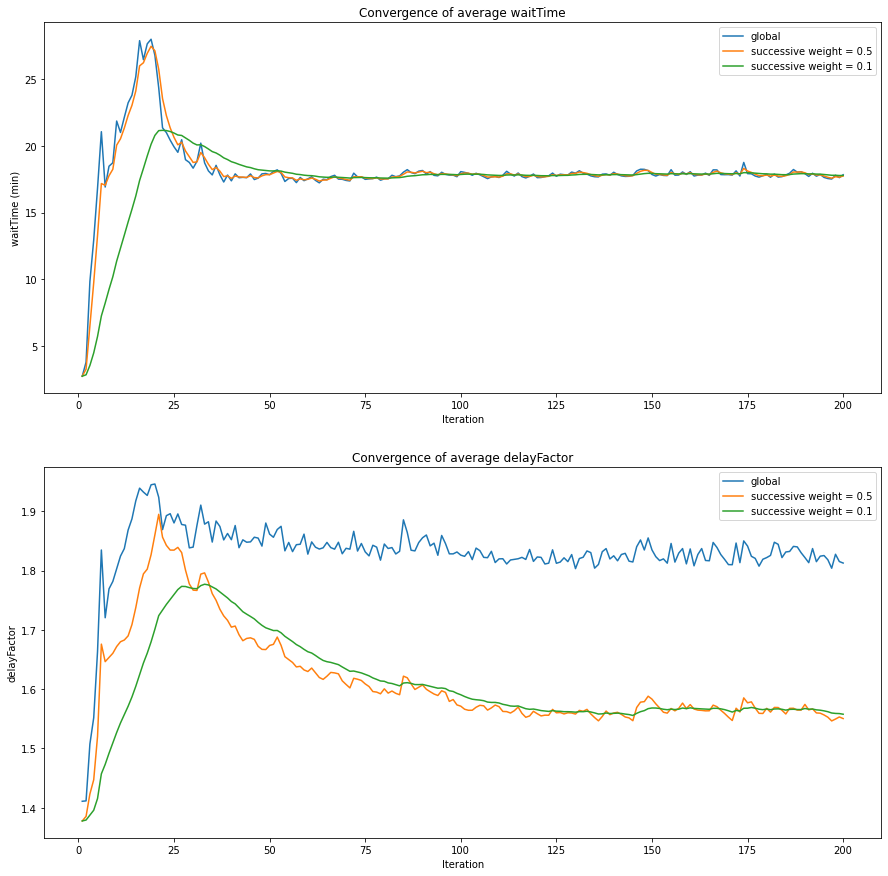

<ipython-input-50-73a2dcc3653e>:11: RuntimeWarning: invalid value encountered in double_scalars
  delayFactors.append(np.float64(it_drt_trips_stats.totalTravelTime.sum()) / it_drt_trips_stats.routerUnsharedTime.sum())
<ipython-input-50-73a2dcc3653e>:11: RuntimeWarning: invalid value encountered in double_scalars
  delayFactors.append(np.float64(it_drt_trips_stats.totalTravelTime.sum()) / it_drt_trips_stats.routerUnsharedTime.sum())


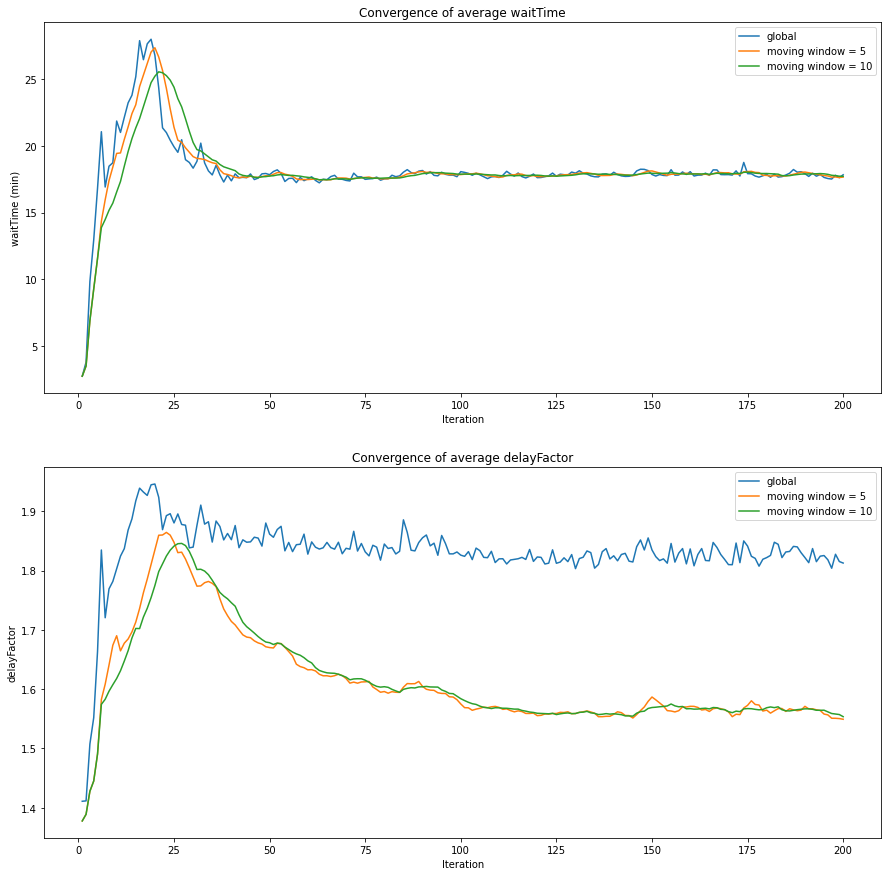

In [53]:
plot_convergence_computed(data, None, [0.5,0.1])
plot_convergence_computed(data, [5,10], None)

In [54]:
def plot_convergence_from_output(output_dict):
    waitTimes_global, delayFactors_global = collect_timeData(output_dict['global_avg'])
    waitTimes_successive, delayFactors_successive = collect_timeData(output_dict['global_successive_avg'])
    waitTimes_moving, delayFactors_moving = collect_timeData(output_dict['global_moving_avg'])
    plt.figure(figsize=(15,15))
    plt.subplot(2,1,1)
    plt.plot(waitTimes_global / 60, label='global')
    plt.plot(waitTimes_successive / 60, label='successive')
    plt.plot(waitTimes_moving / 60, label='moving')
    plt.legend()
    plt.title('Convergence of average waitTime')
    plt.ylabel('waitTime (min)')
    plt.xlabel('Iteration')
    plt.subplot(2,1,2)
    plt.plot(delayFactors_global, label='global')
    plt.plot(delayFactors_successive, label='successive')
    plt.plot(delayFactors_moving, label='moving')
    plt.legend()
    plt.title('Convergence of average delayFactor')
    plt.ylabel('delayFactor')
    plt.xlabel('Iteration')
    plt.show()

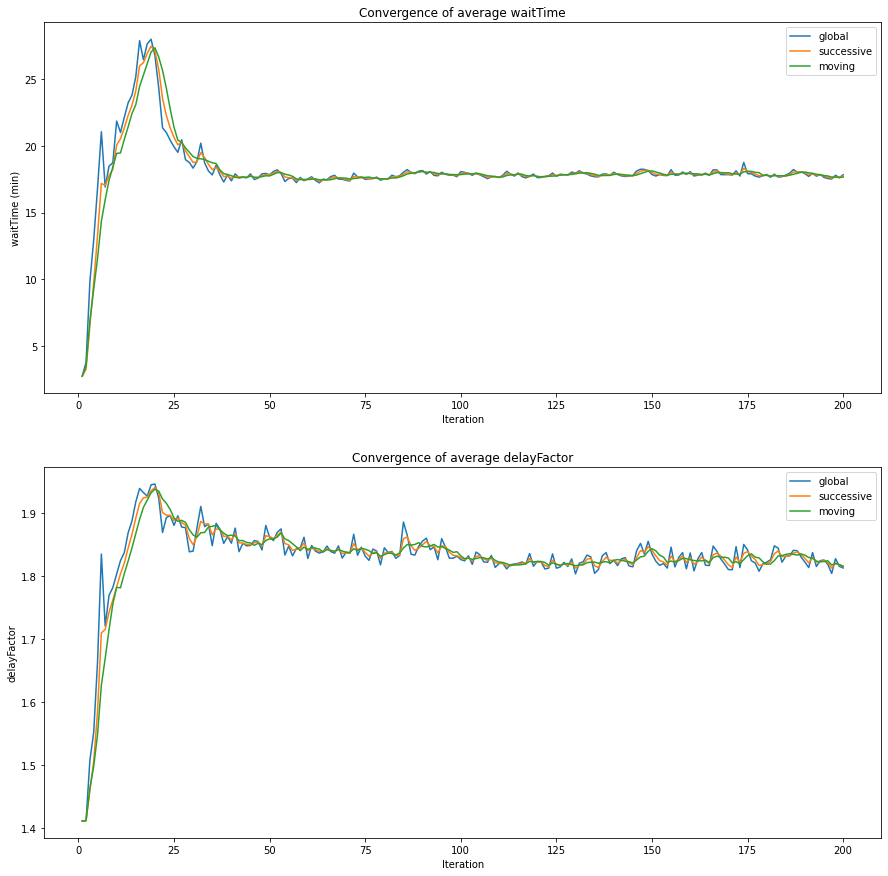

In [55]:
plot_convergence_from_output(data)